# Keras Neural Network Model

Based on open source code: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb

Copyright 2019 The TensorFlow Authors

## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score, precision_score, recall_score
import pickle

from utils import *

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Prepare the data

### Read the AML simulated transaction data

In [4]:
data_path = './data_small_graph/'

combined_directed_G = load_networkx_graphs(data_path)
X, Y, _ = retrieve_node_features_and_labels_tuple(combined_directed_G)

1000_Network_p_0.002_w_0.003.json  - max_node_id= -1
1000_Network_p_0.002_w_0.008.json  - max_node_id= 999
1000_Network_p_0.002_w_0.009.json  - max_node_id= 1999
1000_Network_p_0.004_w_0.004.json  - max_node_id= 2999
1000_Network_p_0.004_w_0.007.json  - max_node_id= 3999
1000_Network_p_0.004_w_0.009.json  - max_node_id= 4999
1000_Network_p_0.005_w_0.009.json  - max_node_id= 5999
1000_Network_p_0.006_w_0.007.json  - max_node_id= 6999
1000_Network_p_0.007_w_0.002.json  - max_node_id= 7999
1000_Network_p_0.007_w_0.009.json  - max_node_id= 8999
1000_Network_p_0.007_w_0.010.json  - max_node_id= 9999
1000_Network_p_0.008_w_0.000.json  - max_node_id= 10999
1000_Network_p_0.008_w_0.005.json  - max_node_id= 11999
1000_Network_p_0.008_w_0.007.json  - max_node_id= 12999
1000_Network_p_0.010_w_0.001.json  - max_node_id= 13999
1000_Network_p_0.010_w_0.006.json  - max_node_id= 14999
1000_Network_p_0.011_w_0.003.json  - max_node_id= 15999
1000_Network_p_0.011_w_0.005.json  - max_node_id= 16999
1000_N

### Splitting the data

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [5]:
train_df, test_df, train_labels, test_labels = train_test_split(X, Y, test_size=0.2)
train_df, val_df, train_labels, val_labels = train_test_split(train_df, train_labels, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_labels)
bool_train_labels = train_labels != 0
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [6]:
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (28160,)
Validation labels shape: (7040,)
Test labels shape: (8800,)
Training features shape: (28160, 129)
Validation features shape: (7040, 129)
Test features shape: (8800, 129)


In [7]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [8]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
    
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## Unweighted model (Baseline)

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


**_Note: this model will not handle the class imbalance well. You will improve it later in this tutorial._**

In [9]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

Test run the model:

In [10]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 2,097
Trainable params: 2,097
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.predict(train_features[:10])

array([[9.0092206e-01],
       [9.8053610e-01],
       [9.9997878e-01],
       [5.7609369e-12],
       [9.5216703e-01],
       [9.2934632e-01],
       [2.5616118e-01],
       [9.2291641e-01],
       [9.9992323e-01],
       [3.2543457e-18]], dtype=float32)

### Improvement: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [42]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2993


In [14]:
neg, pos = np.bincount(Y)
total = neg + pos

initial_bias = np.log([pos/neg])
initial_bias

array([-1.80513385])

In [15]:
pos/(pos + neg)

0.14122727272727273

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [16]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[8.4141466e-05],
       [1.0003928e-06],
       [4.3919852e-05],
       [8.3210021e-03],
       [2.1431088e-05],
       [1.8828904e-02],
       [2.0129012e-04],
       [1.6792525e-03],
       [1.7612055e-03],
       [1.3564019e-09]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [17]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.8007


This initial loss is about 50 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [18]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [19]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [20]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

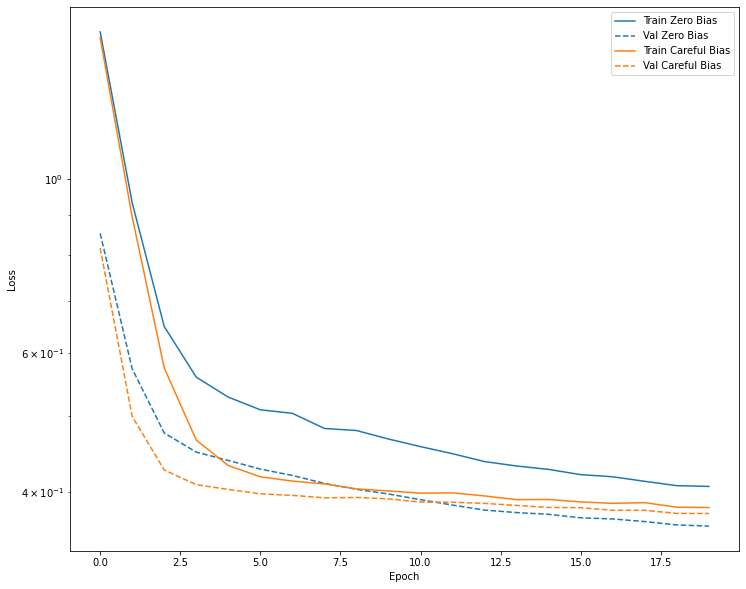

In [22]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [23]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Train on 28160 samples, validate on 7040 samples
Epoch 1/100
28160/28160 [==============================] - 4s 131us/sample - loss: 1.4972 - tp: 336.0000 - fp: 1837.0000 - tn: 22364.0000 - fn: 3623.0000 - accuracy: 0.8061 - precision: 0.1546 - recall: 0.0849 - auc: 0.4696 - val_loss: 0.8219 - val_tp: 20.0000 - val_fp: 33.0000 - val_tn: 5987.0000 - val_fn: 1000.0000 - val_accuracy: 0.8533 - val_precision: 0.3774 - val_recall: 0.0196 - val_auc: 0.4456
Epoch 2/100
28160/28160 [==============================] - 0s 6us/sample - loss: 0.8802 - tp: 569.0000 - fp: 2588.0000 - tn: 21613.0000 - fn: 3390.0000 - accuracy: 0.7877 - precision: 0.1802 - recall: 0.1437 - auc: 0.5020 - val_loss: 0.5136 - val_tp: 40.0000 - val_fp: 44.0000 - val_tn: 5976.0000 - val_fn: 980.0000 - val_accuracy: 0.8545 - val_precision: 0.4762 - val_recall: 0.0392 - val_auc: 0.5098
Epoch 3/100
28160/28160 [==============================] - 0s 6us/sample - loss: 0.5826 - tp: 537.0000 - fp: 1617.0000 - tn: 22584.0000 - fn: 34

28160/28160 [==============================] - 0s 5us/sample - loss: 0.3780 - tp: 390.0000 - fp: 180.0000 - tn: 24021.0000 - fn: 3569.0000 - accuracy: 0.8669 - precision: 0.6842 - recall: 0.0985 - auc: 0.6432 - val_loss: 0.3693 - val_tp: 54.0000 - val_fp: 9.0000 - val_tn: 6011.0000 - val_fn: 966.0000 - val_accuracy: 0.8615 - val_precision: 0.8571 - val_recall: 0.0529 - val_auc: 0.7188
Epoch 22/100
28160/28160 [==============================] - 0s 6us/sample - loss: 0.3790 - tp: 402.0000 - fp: 222.0000 - tn: 23979.0000 - fn: 3557.0000 - accuracy: 0.8658 - precision: 0.6442 - recall: 0.1015 - auc: 0.6420 - val_loss: 0.3680 - val_tp: 57.0000 - val_fp: 7.0000 - val_tn: 6013.0000 - val_fn: 963.0000 - val_accuracy: 0.8622 - val_precision: 0.8906 - val_recall: 0.0559 - val_auc: 0.7232
Epoch 23/100
28160/28160 [==============================] - 0s 6us/sample - loss: 0.3747 - tp: 422.0000 - fp: 162.0000 - tn: 24039.0000 - fn: 3537.0000 - accuracy: 0.8686 - precision: 0.7226 - recall: 0.1066 - a

28160/28160 [==============================] - 0s 6us/sample - loss: 0.3502 - tp: 678.0000 - fp: 212.0000 - tn: 23989.0000 - fn: 3281.0000 - accuracy: 0.8760 - precision: 0.7618 - recall: 0.1713 - auc: 0.7035 - val_loss: 0.3404 - val_tp: 181.0000 - val_fp: 10.0000 - val_tn: 6010.0000 - val_fn: 839.0000 - val_accuracy: 0.8794 - val_precision: 0.9476 - val_recall: 0.1775 - val_auc: 0.7621
Epoch 42/100
28160/28160 [==============================] - 0s 6us/sample - loss: 0.3526 - tp: 681.0000 - fp: 220.0000 - tn: 23981.0000 - fn: 3278.0000 - accuracy: 0.8758 - precision: 0.7558 - recall: 0.1720 - auc: 0.7033 - val_loss: 0.3382 - val_tp: 186.0000 - val_fp: 11.0000 - val_tn: 6009.0000 - val_fn: 834.0000 - val_accuracy: 0.8800 - val_precision: 0.9442 - val_recall: 0.1824 - val_auc: 0.7702
Epoch 43/100
28160/28160 [==============================] - 0s 6us/sample - loss: 0.3496 - tp: 684.0000 - fp: 184.0000 - tn: 24017.0000 - fn: 3275.0000 - accuracy: 0.8772 - precision: 0.7880 - recall: 0.1728

28160/28160 [==============================] - 0s 5us/sample - loss: 0.3371 - tp: 827.0000 - fp: 200.0000 - tn: 24001.0000 - fn: 3132.0000 - accuracy: 0.8817 - precision: 0.8053 - recall: 0.2089 - auc: 0.7284 - val_loss: 0.3232 - val_tp: 230.0000 - val_fp: 12.0000 - val_tn: 6008.0000 - val_fn: 790.0000 - val_accuracy: 0.8861 - val_precision: 0.9504 - val_recall: 0.2255 - val_auc: 0.7811
Epoch 62/100
28160/28160 [==============================] - 0s 5us/sample - loss: 0.3365 - tp: 870.0000 - fp: 231.0000 - tn: 23970.0000 - fn: 3089.0000 - accuracy: 0.8821 - precision: 0.7902 - recall: 0.2198 - auc: 0.7284 - val_loss: 0.3263 - val_tp: 226.0000 - val_fp: 10.0000 - val_tn: 6010.0000 - val_fn: 794.0000 - val_accuracy: 0.8858 - val_precision: 0.9576 - val_recall: 0.2216 - val_auc: 0.7721
Epoch 63/100
28160/28160 [==============================] - 0s 6us/sample - loss: 0.3359 - tp: 871.0000 - fp: 247.0000 - tn: 23954.0000 - fn: 3088.0000 - accuracy: 0.8816 - precision: 0.7791 - recall: 0.2200

28160/28160 [==============================] - 0s 6us/sample - loss: 0.3251 - tp: 983.0000 - fp: 216.0000 - tn: 23985.0000 - fn: 2976.0000 - accuracy: 0.8866 - precision: 0.8198 - recall: 0.2483 - auc: 0.7521 - val_loss: 0.3166 - val_tp: 246.0000 - val_fp: 14.0000 - val_tn: 6006.0000 - val_fn: 774.0000 - val_accuracy: 0.8881 - val_precision: 0.9462 - val_recall: 0.2412 - val_auc: 0.7883
Epoch 82/100
28160/28160 [==============================] - 0s 6us/sample - loss: 0.3251 - tp: 965.0000 - fp: 204.0000 - tn: 23997.0000 - fn: 2994.0000 - accuracy: 0.8864 - precision: 0.8255 - recall: 0.2437 - auc: 0.7501 - val_loss: 0.3164 - val_tp: 249.0000 - val_fp: 15.0000 - val_tn: 6005.0000 - val_fn: 771.0000 - val_accuracy: 0.8884 - val_precision: 0.9432 - val_recall: 0.2441 - val_auc: 0.7900
Epoch 83/100
28160/28160 [==============================] - 0s 6us/sample - loss: 0.3275 - tp: 960.0000 - fp: 228.0000 - tn: 23973.0000 - fn: 2999.0000 - accuracy: 0.8854 - precision: 0.8081 - recall: 0.2425

### Check training history
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [25]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


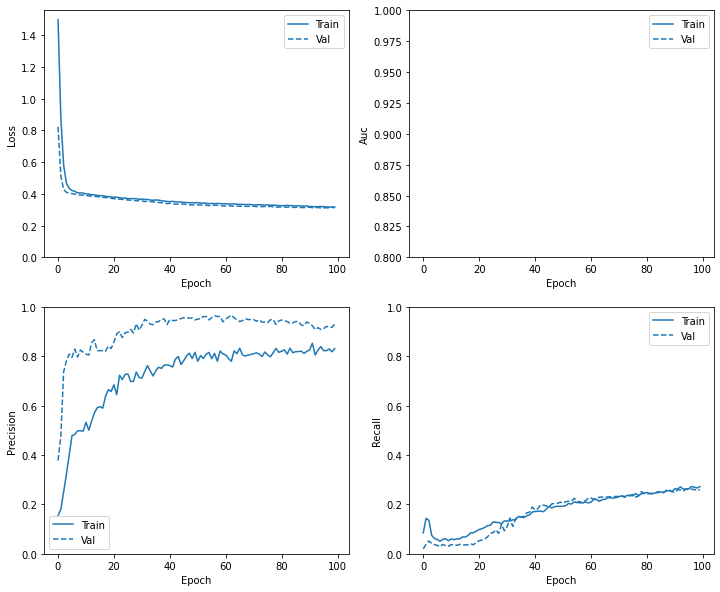

In [26]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [28]:
fp, tp, _ = sklearn.metrics.roc_curve(test_labels, test_predictions_baseline)
auc_score = auc(fp, tp)
print(auc_score)

print(confusion_matrix(test_labels, test_predictions_baseline > 0.5))
print(classification_report(test_labels, test_predictions_baseline > 0.5))

0.790167964014974
[[7530   35]
 [ 918  317]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7565
           1       0.90      0.26      0.40      1235

    accuracy                           0.89      8800
   macro avg       0.90      0.63      0.67      8800
weighted avg       0.89      0.89      0.86      8800



In [29]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

loss :  0.3094342870062048
tp :  317.0
fp :  35.0
tn :  7530.0
fn :  918.0
accuracy :  0.89170456
precision :  0.9005682
recall :  0.25668016
auc :  0.7910601

Legitimate Transactions Detected (True Negatives):  7530
Legitimate Transactions Incorrectly Detected (False Positives):  35
Fraudulent Transactions Missed (False Negatives):  918
Fraudulent Transactions Detected (True Positives):  317
Total Fraudulent Transactions:  1235


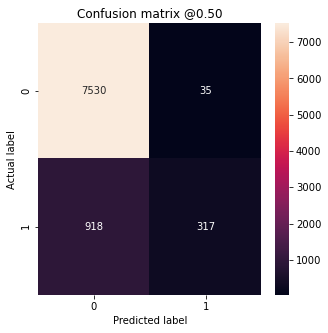

In [30]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [31]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

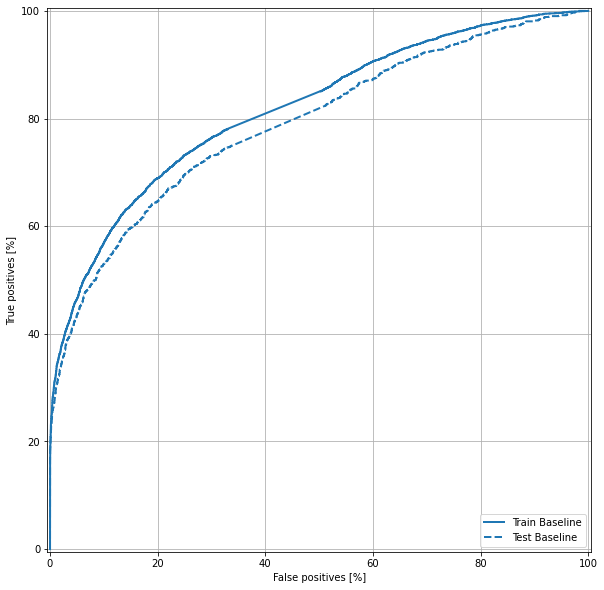

In [32]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

### Save this model

In [33]:
# Save model
filename = 'models/keras_classifier/no_weight_model_highprecision_lowrecall'
model.save(filename)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/keras_classifier/no_weight_model_highprecision_lowrecall\assets


It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [34]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.58
Weight for class 1: 3.54


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [35]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 28160 samples, validate on 7040 samples
Epoch 1/100
28160/28160 [==============================] - 4s 133us/sample - loss: 4.3731 - tp: 588.0000 - fp: 3326.0000 - tn: 20875.0000 - fn: 3371.0000 - accuracy: 0.7622 - precision: 0.1502 - recall: 0.1485 - auc: 0.4765 - val_loss: 1.8605 - val_tp: 266.0000 - val_fp: 1353.0000 - val_tn: 4667.0000 - val_fn: 754.0000 - val_accuracy: 0.7007 - val_precision: 0.1643 - val_recall: 0.2608 - val_auc: 0.4813
Epoch 2/100
28160/28160 [==============================] - 0s 7us/sample - loss: 2.2837 - tp: 1741.0000 - fp: 9597.0000 - tn: 14604.0000 - fn: 2218.0000 - accuracy: 0.5804 - precision: 0.1536 - recall: 0.4398 - auc: 0.5174 - val_loss: 1.1219 - val_tp: 592.0000 - val_fp: 2790.0000 - val_tn: 3230.0000 - val_fn: 428.0000 - val_accuracy: 0.5429 - val_precision: 0.1750 - val_recall: 0.5804 - val_auc: 0.5898
Epoch 3/100
28160/28160 [==============================] - 0s 6us/sample - loss: 1.6070 

Epoch 21/100
28160/28160 [==============================] - 0s 5us/sample - loss: 0.6794 - tp: 1756.0000 - fp: 4306.0000 - tn: 19895.0000 - fn: 2203.0000 - accuracy: 0.7689 - precision: 0.2897 - recall: 0.4435 - auc: 0.6661 - val_loss: 0.6123 - val_tp: 420.0000 - val_fp: 525.0000 - val_tn: 5495.0000 - val_fn: 600.0000 - val_accuracy: 0.8402 - val_precision: 0.4444 - val_recall: 0.4118 - val_auc: 0.7380
Epoch 22/100
28160/28160 [==============================] - 0s 5us/sample - loss: 0.6829 - tp: 1756.0000 - fp: 4348.0000 - tn: 19853.0000 - fn: 2203.0000 - accuracy: 0.7674 - precision: 0.2877 - recall: 0.4435 - auc: 0.6600 - val_loss: 0.6092 - val_tp: 423.0000 - val_fp: 522.0000 - val_tn: 5498.0000 - val_fn: 597.0000 - val_accuracy: 0.8411 - val_precision: 0.4476 - val_recall: 0.4147 - val_auc: 0.7399
Epoch 23/100
28160/28160 [==============================] - 0s 6us/sample - loss: 0.6761 - tp: 1730.0000 - fp: 4010.0000 - tn: 20191.0000 - fn: 2229.0000 - accuracy: 0.7784 - precision: 0.

28160/28160 [==============================] - 0s 5us/sample - loss: 0.6293 - tp: 1862.0000 - fp: 3662.0000 - tn: 20539.0000 - fn: 2097.0000 - accuracy: 0.7955 - precision: 0.3371 - recall: 0.4703 - auc: 0.7009 - val_loss: 0.5773 - val_tp: 482.0000 - val_fp: 477.0000 - val_tn: 5543.0000 - val_fn: 538.0000 - val_accuracy: 0.8558 - val_precision: 0.5026 - val_recall: 0.4725 - val_auc: 0.7721
Epoch 42/100
28160/28160 [==============================] - 0s 6us/sample - loss: 0.6176 - tp: 1923.0000 - fp: 3559.0000 - tn: 20642.0000 - fn: 2036.0000 - accuracy: 0.8013 - precision: 0.3508 - recall: 0.4857 - auc: 0.7133 - val_loss: 0.5742 - val_tp: 490.0000 - val_fp: 523.0000 - val_tn: 5497.0000 - val_fn: 530.0000 - val_accuracy: 0.8504 - val_precision: 0.4837 - val_recall: 0.4804 - val_auc: 0.7738
Epoch 43/100
28160/28160 [==============================] - 0s 5us/sample - loss: 0.6213 - tp: 1920.0000 - fp: 3680.0000 - tn: 20521.0000 - fn: 2039.0000 - accuracy: 0.7969 - precision: 0.3429 - recall

28160/28160 [==============================] - 0s 5us/sample - loss: 0.5838 - tp: 2048.0000 - fp: 3452.0000 - tn: 20749.0000 - fn: 1911.0000 - accuracy: 0.8096 - precision: 0.3724 - recall: 0.5173 - auc: 0.7449 - val_loss: 0.5540 - val_tp: 539.0000 - val_fp: 648.0000 - val_tn: 5372.0000 - val_fn: 481.0000 - val_accuracy: 0.8396 - val_precision: 0.4541 - val_recall: 0.5284 - val_auc: 0.7891
Epoch 62/100
28160/28160 [==============================] - 0s 5us/sample - loss: 0.5873 - tp: 2011.0000 - fp: 3296.0000 - tn: 20905.0000 - fn: 1948.0000 - accuracy: 0.8138 - precision: 0.3789 - recall: 0.5080 - auc: 0.7400 - val_loss: 0.5604 - val_tp: 507.0000 - val_fp: 496.0000 - val_tn: 5524.0000 - val_fn: 513.0000 - val_accuracy: 0.8567 - val_precision: 0.5055 - val_recall: 0.4971 - val_auc: 0.7877
Epoch 63/100
28160/28160 [==============================] - 0s 7us/sample - loss: 0.5897 - tp: 2007.0000 - fp: 3465.0000 - tn: 20736.0000 - fn: 1952.0000 - accuracy: 0.8076 - precision: 0.3668 - recall

28160/28160 [==============================] - 0s 5us/sample - loss: 0.5654 - tp: 2160.0000 - fp: 3314.0000 - tn: 20887.0000 - fn: 1799.0000 - accuracy: 0.8184 - precision: 0.3946 - recall: 0.5456 - auc: 0.7623 - val_loss: 0.5483 - val_tp: 529.0000 - val_fp: 573.0000 - val_tn: 5447.0000 - val_fn: 491.0000 - val_accuracy: 0.8489 - val_precision: 0.4800 - val_recall: 0.5186 - val_auc: 0.7962
Epoch 82/100
28160/28160 [==============================] - 0s 5us/sample - loss: 0.5677 - tp: 2120.0000 - fp: 3275.0000 - tn: 20926.0000 - fn: 1839.0000 - accuracy: 0.8184 - precision: 0.3930 - recall: 0.5355 - auc: 0.7599 - val_loss: 0.5475 - val_tp: 537.0000 - val_fp: 582.0000 - val_tn: 5438.0000 - val_fn: 483.0000 - val_accuracy: 0.8487 - val_precision: 0.4799 - val_recall: 0.5265 - val_auc: 0.7964
Epoch 83/100
28160/28160 [==============================] - 0s 6us/sample - loss: 0.5648 - tp: 2112.0000 - fp: 3252.0000 - tn: 20949.0000 - fn: 1847.0000 - accuracy: 0.8189 - precision: 0.3937 - recall

### Check training history

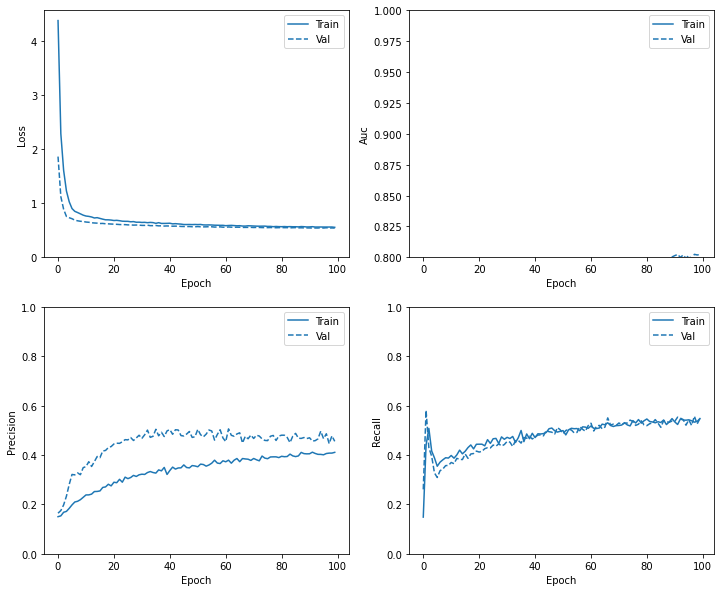

In [36]:
plot_metrics(weighted_history)

### Evaluate metrics

In [37]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

In [38]:
fp, tp, _ = sklearn.metrics.roc_curve(test_labels, test_predictions_weighted)
auc_score = auc(fp, tp)
print(auc_score)

print(confusion_matrix(test_labels, test_predictions_weighted > 0.5))
print(classification_report(test_labels, test_predictions_weighted > 0.5))

0.7910857320228734
[[6676  889]
 [ 539  696]]
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      7565
           1       0.44      0.56      0.49      1235

    accuracy                           0.84      8800
   macro avg       0.68      0.72      0.70      8800
weighted avg       0.86      0.84      0.85      8800



loss :  0.4998924679105932
tp :  696.0
fp :  889.0
tn :  6676.0
fn :  539.0
accuracy :  0.83772725
precision :  0.43911672
recall :  0.56356275
auc :  0.7912069

Legitimate Transactions Detected (True Negatives):  6676
Legitimate Transactions Incorrectly Detected (False Positives):  889
Fraudulent Transactions Missed (False Negatives):  539
Fraudulent Transactions Detected (True Positives):  696
Total Fraudulent Transactions:  1235


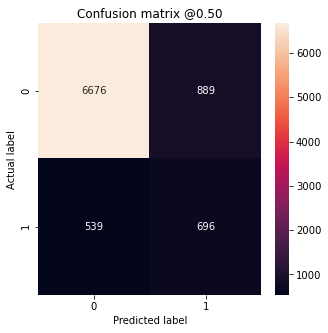

In [39]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

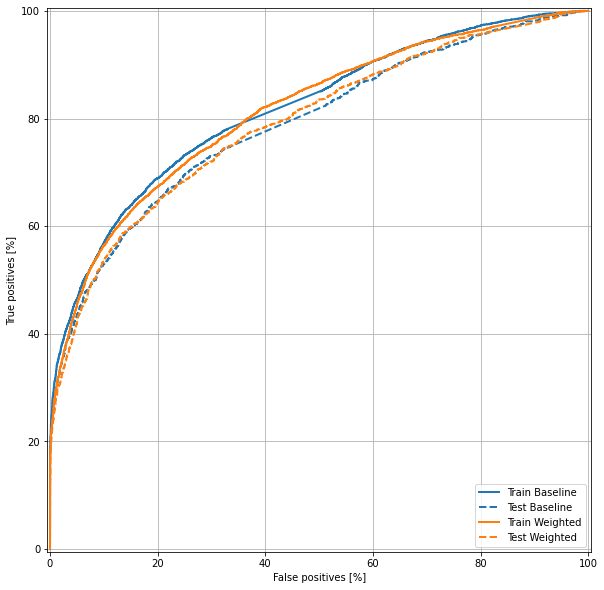

In [40]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

### Save this model

In [41]:
# Save model
filename = 'models/keras_classifier/weighted_model_lowprecision_highrecall'
weighted_model.save(filename)

INFO:tensorflow:Assets written to: models/keras_classifier/weighted_model_lowprecision_highrecall\assets
